In [1]:
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import json
import os
import time
import glob

class BboxPromptDemo:
    def __init__(self, directory_path):
        self.directory_path = directory_path
        self.image_files = sorted(glob.glob(os.path.join(directory_path, '*.jpg')))  # List all jpg files
        self.current_image_index = 0
        self.image = None
        self.fig, self.ax = None, None
        self.bbox = None  # Store current bounding box
        self.bboxes = {}  # Dictionary to store all bounding boxes
        self.clear_count = 0  # Initialize clear count
        self.timestamps = {
            "first_click": None,
            "save_clicked": None
        }
        self.currently_selecting = False
        self.load_image()  # Load the first image automatically

    def load_image(self):
        """Load an image from a file and display it."""
        if self.image_files:
            image_path = self.image_files[self.current_image_index]
            self.image = plt.imread(image_path)
            self.show_image()
        else:
            print("No images found in the directory.")

    def show_image(self):
        """Show the image with interactive bounding box drawing capabilities."""
        if self.image is not None:
            clear_output(wait=True)  # Clear previous outputs

            # Use a fixed large figure size
            self.fig, self.ax = plt.subplots(figsize=(12, 12))  # Fixed large size for better visibility

            # Display the image
            self.ax.imshow(self.image)
            self.ax.axis('off')  # Turn off axis to focus on the image

            # Get the filename from the path and set it as the title of the plot
            filename = os.path.basename(self.image_files[self.current_image_index])
            self.ax.set_title(filename, fontsize=15)  # Set the image filename as the title

            self.fig.canvas.mpl_connect('button_press_event', self.on_press)
            self.fig.canvas.mpl_connect('button_release_event', self.on_release)
            self.fig.canvas.mpl_connect('motion_notify_event', self.on_motion)
            self.add_buttons()  # Add navigation and action buttons
        else:
            print("No image loaded.")

    def on_press(self, event):
        """Handle mouse button press events."""
        if event.inaxes != self.ax:
            return  # Ignore clicks outside the axes

        self.x0, self.y0 = event.xdata, event.ydata
        self.currently_selecting = True
        self.timestamps["first_click"] = time.time()

        self.rect = plt.Rectangle(
            (self.x0, self.y0),
            1, 1, linestyle="--",
            edgecolor="crimson", fill=False
        )
        self.ax.add_patch(self.rect)

    def on_release(self, event):
        """Handle mouse button release events."""
        if not self.currently_selecting:
            return

        self.x1, self.y1 = event.xdata, event.ydata
        self.currently_selecting = False
        self.timestamps["save_clicked"] = time.time()

        # Draw the final bounding box
        self.rect.set_width(self.x1 - self.x0)
        self.rect.set_height(self.y1 - self.y0)
        self.rect.set_visible(True)
        self.fig.canvas.draw_idle()

        # Save the bounding box
        self.bbox = [self.x0, self.y0, self.x1, self.y1]
        print(f"Bounding box saved: {self.bbox}")

    def on_motion(self, event):
        """Handle mouse motion events."""
        if not self.currently_selecting:
            return

        self.x1, self.y1 = event.xdata, event.ydata

        # Update the rectangle's size
        self.rect.set_width(self.x1 - self.x0)
        self.rect.set_height(self.y1 - self.y0)
        self.fig.canvas.draw_idle()

    def add_buttons(self):
        """Add navigation and action buttons below the figure."""
        previous_button = widgets.Button(description="Previous")
        next_button = widgets.Button(description="Next")
        save_button = widgets.Button(description="Save")
        clear_button = widgets.Button(description="Clear")
        end_button = widgets.Button(description="End")
        previous_button.on_click(self.on_previous_clicked)
        next_button.on_click(self.on_next_clicked)
        save_button.on_click(self.on_save_clicked)
        clear_button.on_click(self.on_clear_clicked)
        end_button.on_click(self.on_end_clicked)
        button_box = widgets.HBox([previous_button, next_button, save_button, clear_button, end_button])
        display(button_box)

    def on_previous_clicked(self, b):
        """Go to the previous image."""
        if self.current_image_index > 0:
            self.current_image_index -= 1
            self.load_image()

    def on_next_clicked(self, b):
        """Go to the next image."""
        self.clear_count = 0
        if self.current_image_index < len(self.image_files) - 1:
            self.current_image_index += 1
            self.load_image()

    def on_save_clicked(self, b):
        """Handle Save button click: save bounding box data for current image."""
        if self.bbox:
            filename = os.path.basename(self.image_files[self.current_image_index])
            if filename not in self.bboxes:
                self.bboxes[filename] = []
            bbox_data = {
                "bbox": list(self.bbox),
                "timestamps": self.timestamps,
                "clear_count": self.clear_count
            }
            self.bboxes[filename].append(bbox_data)
            self.bbox = None  # Reset the current bounding box
            print(f"BBox data saved for {filename}. Total entries: {len(self.bboxes[filename])}")

    def on_clear_clicked(self, b):
        """Clear the drawing, reset bounding box data, and increment clear count."""
        self.clear_count += 1  # Increment clear count
        self.bbox = None
        self.ax.clear()
        self.ax.imshow(self.image)
        self.ax.axis('off')
        self.fig.canvas.draw()
        print(f"Clear button clicked {self.clear_count} times.")  # Diagnostic message

    def on_end_clicked(self, b):
        """Save all bounding box data to a JSON file when ending the session."""
        file_path = "all_bbox_data.json"
        with open(file_path, 'w') as f:
            json.dump(self.bboxes, f, indent=4)
        print(f"All bounding box data saved to {file_path}. Session ended.")


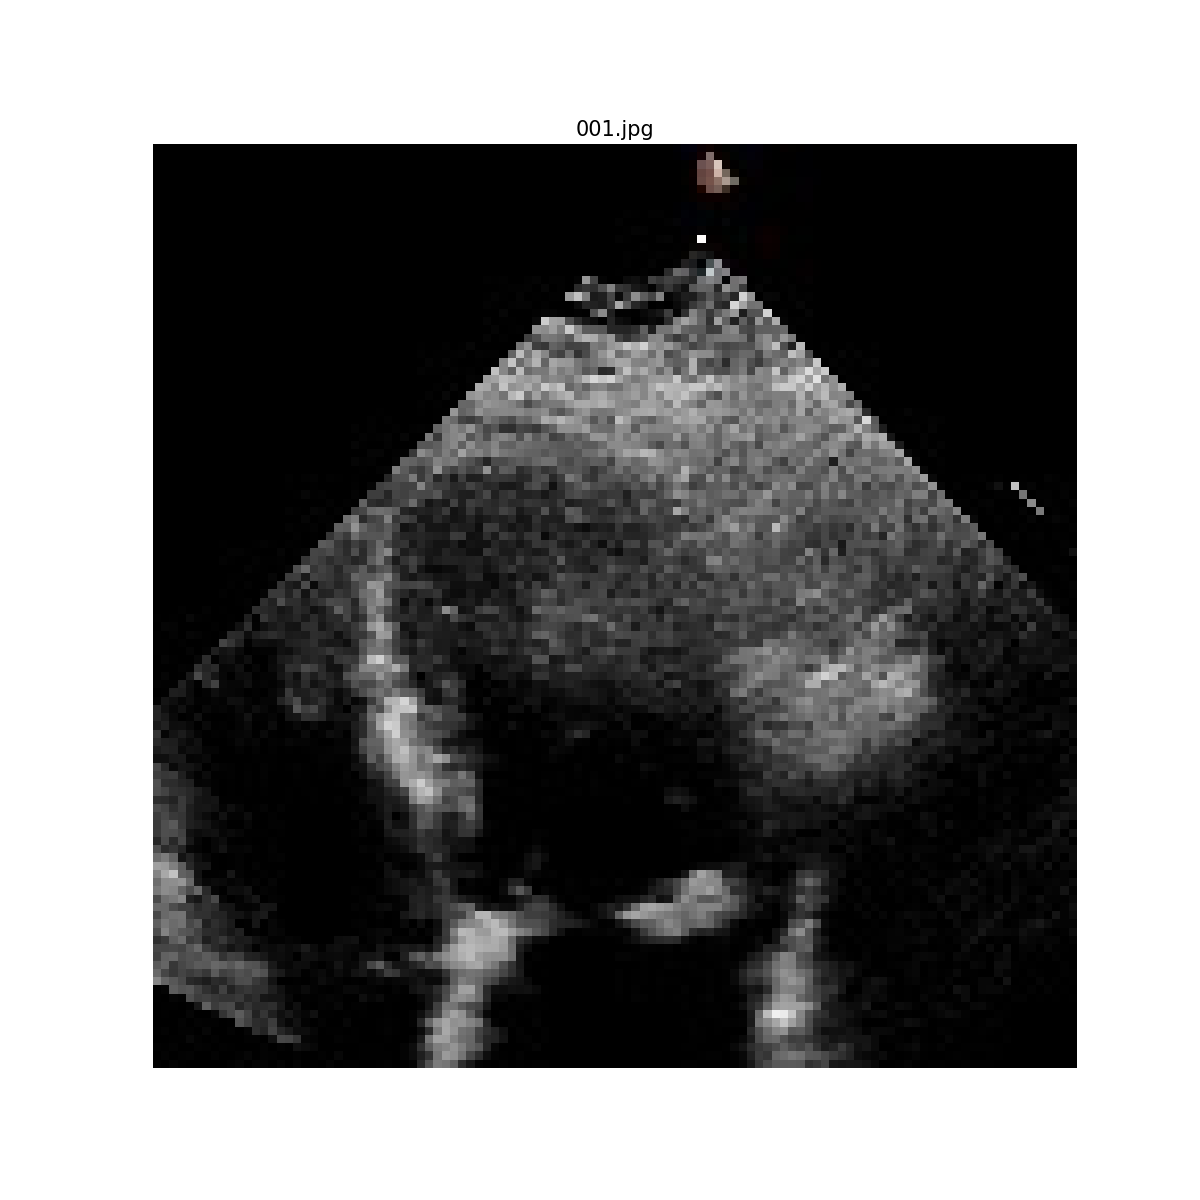

No such comm: 8d745eaed19b4bbb819ef56105a756cc


In [3]:

# Usage example
demo = BboxPromptDemo("/home/omen/wasan/SAM/Annotation Study-8-13-24/Annotation Study")


In [11]:
import torch
import matplotlib.pyplot as plt
import cv2
import os
from ultralytics import SAM
import json

# Load the SAM model
model = SAM("sam_b.pt")


In [19]:
def preprocess_image(image, target_size=(640, 640)):
    """Resize and normalize the image to make it compatible with the model."""
    # Resize the image to the target size
    image_resized = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Normalize the image to [0, 1]
    image_normalized = image_resized / 255.0

    # Convert the image to a PyTorch tensor and add batch dimension
    image_tensor = torch.tensor(image_normalized).float().permute(2, 0, 1).unsqueeze(0)

    return image_tensor, image_resized

def save_image_with_mask(image_path, mask_array, output_folder):
    """Overlay the mask on the original image and save it."""
    image = plt.imread(image_path)

    # Convert the boolean mask to uint8
    mask_uint8 = (mask_array * 255).astype(np.uint8)

    # Resize the mask to match the original image dimensions
    mask_resized = cv2.resize(mask_uint8, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_LINEAR)

    # Create the segmented folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Create the overlay by combining the image and mask
    plt.imshow(image)
    plt.imshow(mask_resized, alpha=0.5, cmap="magma")
    plt.axis('off')

    # Save the figure
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_folder, filename)
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the plot to avoid displaying it inline


In [20]:

# Load the bounding box data
with open("all_bbox_data.json", "r") as f:
    bbox_data = json.load(f)

image_file = list(bbox_data.keys())[0]  # Get the first image filename
bbox_info = bbox_data[image_file][0]  # Get the first bounding box for this image

# Full path to the image
image_path = f"/home/omen/wasan/SAM/Annotation Study-8-13-24/Annotation Study/{image_file}"

# Extract the bounding box coordinates
bbox = bbox_info['bbox']  # This should be a list [x1, y1, x2, y2]


In [21]:

# Run inference with the bounding box prompt
results = model(image_path, bboxes=[bbox])



image 1/1 /home/omen/wasan/SAM/Annotation Study-8-13-24/Annotation Study/001.jpg: 1024x1024 9944.5ms
Speed: 9.4ms preprocess, 9944.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)


In [22]:
from matplotlib import colormaps #use whatever needed
list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

In [23]:
# Folder to save the segmented images
output_folder = "segmented"

# Iterate over all images and bounding boxes
for image_file, bbox_list in bbox_data.items():
    # Full path to the image
    image_path = f"/home/omen/wasan/SAM/Annotation Study-8-13-24/Annotation Study/{image_file}"

    # Preprocess the image
    image = plt.imread(image_path)
    image_tensor, image_resized = preprocess_image(image, target_size=(640, 640))

    # Process each bounding box for the image
    for bbox_info in bbox_list:
        # Extract the bounding box coordinates
        bbox = bbox_info['bbox']

        # Run inference with the bounding box prompt
        results = model(image_path, bboxes=[bbox])

        # Extract the mask and save the image with mask overlay
        for result in results:
            masks = result.masks  # Access the masks for the current result
            mask_array = masks.data[0].cpu().numpy()  # Assuming you want the first mask
            save_image_with_mask(image_path, mask_array, output_folder)

# Final message
print(f"Segmented images have been saved in the '{output_folder}' folder.")


image 1/1 /home/omen/wasan/SAM/Annotation Study-8-13-24/Annotation Study/001.jpg: 1024x1024 9929.5ms
Speed: 10.6ms preprocess, 9929.5ms inference, 0.3ms postprocess per image at shape (1, 3, 1024, 1024)
Segmented images have been saved in the 'segmented' folder.
